In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating project at `~/Documents/eth_courses/notebooks/dynamics/julia/demos/quad_2d`


In [221]:
# Pkg.add("Revise");
Pkg.add("BenchmarkTools")

   Resolving package versions...
   Installed BenchmarkTools ─ v1.3.2
    Updating `~/Documents/eth_courses/notebooks/dynamics/julia/demos/quad_2d/Project.toml`
  [6e4b80f9] + BenchmarkTools v1.3.2
    Updating `~/Documents/eth_courses/notebooks/dynamics/julia/demos/quad_2d/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v1.3.2
  [9abbd945] + Profile
Precompiling project...
  ✓ BenchmarkTools
  ✓ quad_2d
  2 dependencies successfully precompiled in 14 seconds


In [14]:
using Revise
using ModelingToolkit, LinearAlgebra
using GLMakie
using ControlSystems
using DifferentialEquations
using StaticArrays
# using Plots

include("utilities.jl")
include("types.jl")
include("linearize.jl")

linearize_system (generic function with 1 method)

## Utilities 

In [72]:
# 2D rotation matrix
R_2D(θ::Float64) = SA_F64[cos(θ) -sin(θ); sin(θ) cos(θ)];

In [69]:
motor_left = BLDCMotor(0, 12.5);
motor_right = BLDCMotor(0, 12.5);

quad_obj = Quad2d(1.0, 0.1, 0.003, motor_left, motor_right);
sim_params = SimParams(6,2,3, 0.01);
safety_box = SafetyBox(10, 10, 10, -10, -10, 0);

# Linearization

In [67]:
# equilibrium point
x₀ = Pose2D(2,1,0,0,0,0)

const thrust_equilibirum::Float64 = 9.81;
        
const f_1_eq_equilibirum::Float64 = thrust_equilibirum/2
const f_2_eq_equilibirum::Float64 = thrust_equilibirum/2

sys_c, sys_d, AB_symbolic = linearize_system(sim_params.Ts, x₀, quad_obj,[f_1_eq, f_2_eq]);

# LQR Controller

### Design controller

In [115]:
Q       = Diagonal([1,1,1,1,1,1]) # Weighting matrix for state
R       = Diagonal([1,1]) # Weighting matrix for input

# Compute LQR gain matrix
K      = lqr(sys_d,Q,R)

# K = SMatrix{2,6}(K)

2×6 Matrix{Float64}:
 -0.544864  0.69938   3.16405  -0.805202  1.09019   0.625058
  0.544864  0.69938  -3.16405   0.805202  1.09019  -0.625058

## Discrete-time Linear Simulation

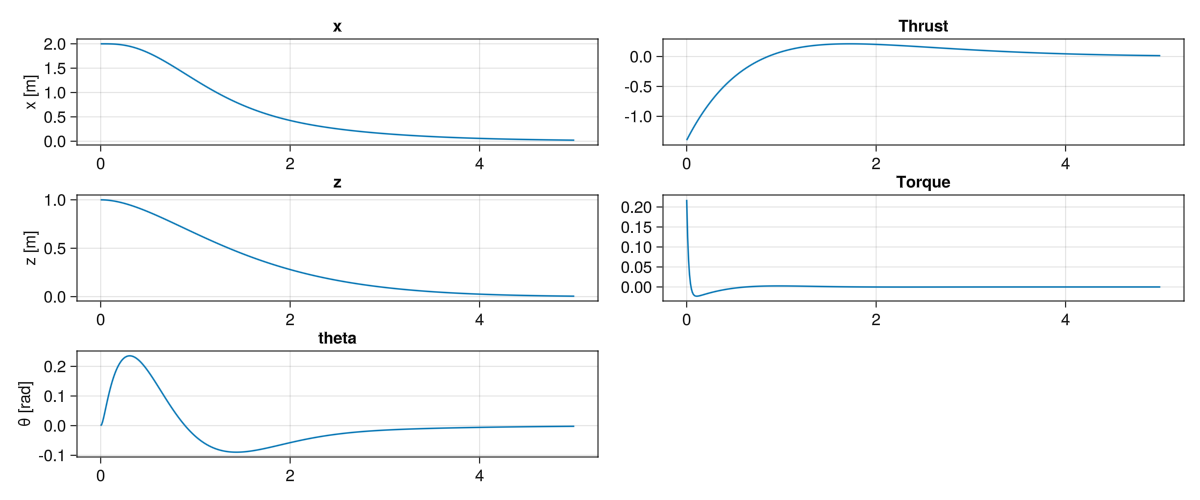

In [135]:
# Simulation
u_l(x,t)  = -K*x 
t       = 0:sim_params.Ts:5              # Time vector
x0      = [2,1,0,0,0,0]               # Initial condition

y, t, x, uout = lsim(sys_d,u_l,t,x0=x0)

quad_2d_plot_lsim(t,x)

## Non-linear Simulation using DifferentialEquationsjl

In [208]:
function quad_2d_dynamics(X::Vector{Float64}, U::Vector{Float64}, params::NamedTuple)

    # extract the parameters
    m, g, l, I_xx = params
    
    g_vec = SA_F64[0;g] # use static array

    y = X[1]
    z = X[2]
    θ = X[3]
    ẏ = X[4]
    ż = X[5]
    θ̇ = X[6]
    
     # get the control input
    f_1 = U[1]
    f_2 = U[2]
    
    # compute thrust, torque
    f_thrust = f_1 + f_2
    a_thrust = (f_thrust / m) # mass normalized thrust 
    
    τ = (f_1 - f_2) * l

    # translation E.O.M
    f = SA_F64[0; a_thrust]
    (ÿ, z̈) = R_2D(θ)*f + g_vec 

    # rotational E.O.M
    θ̈ = τ / I_xx

    return (ẏ, ż, θ̇, ÿ, z̈, θ̈ )
end

#Define the problem
function quad_2d(d_state, state, params, t)
    
    # extract the state
    X = state[1:sim_params.nx]

    # extract the control input
    U = state[sim_params.nx+1:end]

    (ẏ, ż, θ̇, ÿ, z̈, θ̈) = quad_2d_dynamics(X,U,params)
    
    d_state[1], d_state[2], d_state[3] = ẏ, ż, θ̇
    d_state[4], d_state[5], d_state[6] = ÿ, z̈, θ̈
end

quad_2d (generic function with 1 method)

In [209]:
# run at every timestep
condition(u,t,integrator) = true

function affect!(integrator)

     # Extract the state 
    X = integrator.u[1:sim_params.nx] 
    
    y::Float64 = X[1]
    z::Float64 = X[2]
    θ::Float64 = X[3]
    ẏ::Float64 = X[4]
    ż::Float64 = X[5]
    θ̇::Float64 = X[6]

    # Limit operating space 
    if z > params.safety_box.z_max
        z = clamp(z, params.safety_box.z_min, params.safety_box.z_max)
        ż = 0
        println("Z operational space constraint violated !")
        terminate!(integrator)

    elseif z < params.safety_box.z_min
        z = clamp(z, params.safety_box.z_min, params.safety_box.z_max)
        ż = 0
        println("Landed !")
        terminate!(integrator)
    end

    if y < params.safety_box.y_min || y > params.safety_box.y_max
        y = clamp(y, params.safety_box.y_min, params.safety_box.y_max)
        ẏ = 0
        println("Y operational space constraint violated !")
        terminate!(integrator)
    end

end

cb = DiscreteCallback(condition,affect!)

DiscreteCallback{typeof(condition), typeof(affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT)}(condition, affect!, SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, Bool[1, 1])

Landed !


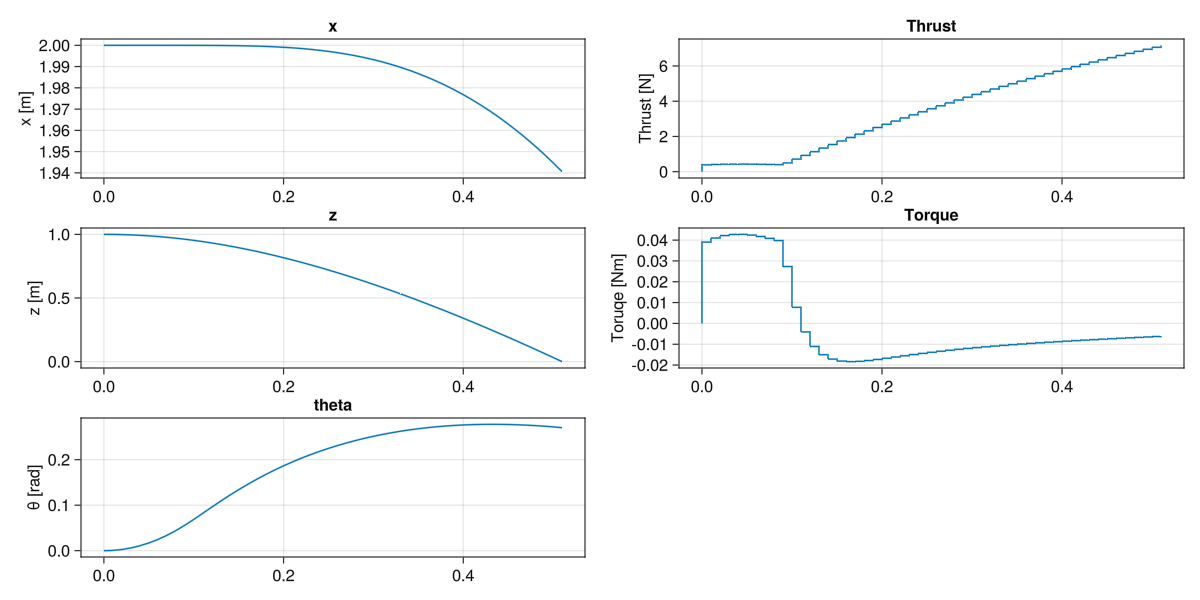

In [217]:
control_cb = PeriodicCallback(sim_params.Ts, initial_affect=true) do integrator
    p = integrator.p    # Extract the parameter object from the integrator
    nx = 6
    
    # # Extract the parameters
    # (; m, g, l, I_xx, safety_box) = params

    # Extract the state 
    X = integrator.u[1:sim_params.nx] 

    # compute control input
    U = - K * X

    f_1 = U[1]
    f_2 = U[2]

    # constrain the control input
    f_1 = clamp(f_1, quad_obj.motor_left.thrust_min, quad_obj.motor_left.thrust_max)
    f_2 = clamp(f_2, quad_obj.motor_right.thrust_min, quad_obj.motor_right.thrust_max)

    # println("Control: $(U)")
    
    #Update the control-signal
    integrator.u[sim_params.nx+1:end] .= SA_F64[f_1, f_2]
end

# parameters
params = (; m=quad_obj.m, g=-9.81, l=quad_obj.L, I_xx = 0.003, safety_box = safety_box)

#Initial Conditions
x₀ = Pose2D(2,1,0,0,0,0)

tspan = (0.0, 10.0);

initial_state = [x₀.y, x₀.z, x₀.θ, x₀.ẏ, x₀.ż, x₀.θ̇]; # state
u₀ = [0,0]; # control

initial_conditions = vcat(initial_state,u₀)

#Pass to solvers
cb_set = CallbackSet(control_cb,cb)
prob = ODEProblem(quad_2d, initial_conditions, tspan, params, callback=cb_set);
sol = solve(prob, Tsit5(), abstol=1e-8, reltol=1e-8);

quad_2d_plot_normal(sol)

## Benchmarking 

In [235]:
@btime solve(prob, Tsit5(), abstol=1e-8, reltol=1e-8, save_everystep = false);

  3.595 ms (49 allocations: 4.00 KiB)


In [234]:
@timev solve(prob, Tsit5(), abstol=1e-8, reltol=1e-8, save_everystep = false);

  0.017423 seconds (106.88 k allocations: 8.967 MiB)
elapsed time (ns):  17422987
gc time (ns):       0
bytes allocated:    9402608
pool allocs:        106863
non-pool GC allocs: 12
minor collections:  0
full collections:   0


In [227]:
using BenchmarkTools

begin

function lorenz!(du, u, p, t)
    du[1] = 10.0 * (u[2] - u[1])
    du[2] = u[1] * (28.0 - u[3]) - u[2]
    du[3] = u[1] * u[2] - (8 / 3) * u[3]
end

u0 = [1.0; 0.0; 0.0]
tspan = (0.0, 100.0)
prob = ODEProblem(lorenz!, u0, tspan)
@btime solve(prob, Tsit5(), save_everystep = false);
    
end


  398.541 μs (49 allocations: 4.00 KiB)


retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
   0.0
 100.0
u: 2-element Vector{Vector{Float64}}:
 [1.0, 0.0, 0.0]
 [3.8020065515435855, 2.787021797920187, 23.420567509786622]